usable parts on disk: 49987
split -> train 39989, val 4998, test 5000


Indexing graphs: 100%|██████████| 5000/5000 [01:51<00:00, 44.70it/s]


in_dim: 10
Model params: 1.47M
torch.compile: backend='eager' (Windows/no Triton)


C:\Users\sregans2\AppData\Local\Temp\ipykernel_1828\4116431614.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda"), dtype=torch.float16):
C:\Users\sregans2\AppData\Local\Temp\ipykernel_1828\4116431614.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda"), dtype=torch.float16):
C:\Users\sregans2\AppData\Local\Temp\ipykernel_1828\4116431614.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda"), dtype=torch.float16):
C:\Users\sregans2\AppData\Local\Temp\ipykernel_1828\4116431614.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast

ep001 | train 2.2698/0.473 | val 1.7589/0.560 | lr 3.00e-04


C:\Users\sregans2\AppData\Local\Temp\ipykernel_1828\4116431614.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda"), dtype=torch.float16):


ep002 | train 1.9061/0.591 | val 1.7103/0.620 | lr 3.00e-04
ep003 | train 1.7884/0.632 | val 1.5502/0.675 | lr 3.00e-04
ep004 | train 1.7206/0.657 | val 1.5254/0.688 | lr 3.00e-04
ep005 | train 1.6677/0.675 | val 1.6224/0.634 | lr 3.00e-04
ep006 | train 1.6310/0.686 | val 1.4660/0.711 | lr 3.00e-04
ep007 | train 1.5987/0.696 | val 1.4252/0.723 | lr 3.00e-04
ep008 | train 1.5715/0.705 | val 1.4427/0.698 | lr 3.00e-04
ep009 | train 1.5498/0.713 | val 1.3851/0.729 | lr 3.00e-04
ep010 | train 1.5281/0.719 | val 1.4025/0.736 | lr 3.00e-04
ep011 | train 1.5104/0.726 | val 1.4152/0.731 | lr 3.00e-04
ep012 | train 1.4944/0.729 | val 1.3357/0.754 | lr 3.00e-04
ep013 | train 1.4806/0.733 | val 1.3756/0.741 | lr 2.99e-04
ep014 | train 1.4665/0.738 | val 1.3279/0.756 | lr 2.99e-04
ep015 | train 1.4537/0.742 | val 1.2837/0.777 | lr 2.99e-04
ep016 | train 1.4420/0.746 | val 1.3258/0.757 | lr 2.99e-04
ep017 | train 1.4319/0.750 | val 1.3196/0.771 | lr 2.99e-04
ep018 | train 1.4222/0.752 | val 1.2972/

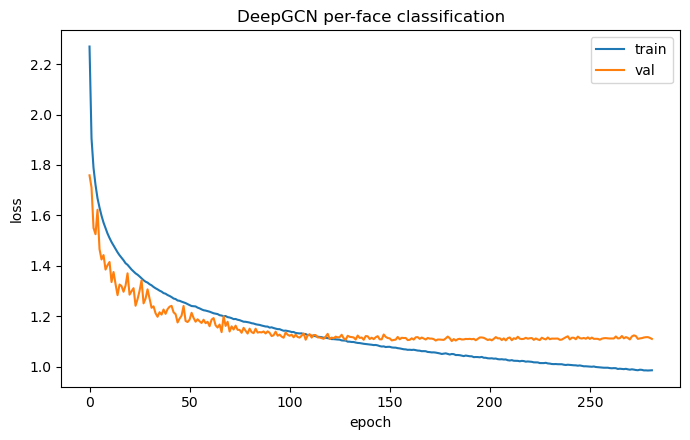

In [1]:
# gnn_train_infer.py  (heavier/deeper)
import os, sys, json, pickle, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import GradScaler
import matplotlib.pyplot as plt

# ---- PyG ----
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

from dataset_loader import load_sample, build_node_features, get_available_ids, split_ids

# ========= config =========
ROOT = Path("./dataset/dataset_generation/data")
MAX_ID_SCAN   = 50000
NUM_CLASSES   = 25  # len(feat_names) below
EPOCHS        = 500
HIDDEN        = 400     # wider
LAYERS        = 8       # deeper
DROPOUT       = 0.30
BATCH_SIZE    = 64
LR            = 3e-4
WEIGHT_DECAY  = 1e-4
LABEL_SMOOTH  = 0.05
CLIP_NORM     = 1.0
PATIENCE      = 100
SEED          = 13
USE_COMPILE   = True     # will fall back to eager on Windows/no Triton

feat_names = [
    'chamfer', 'through_hole', 'triangular_passage', 'rectangular_passage', '6sides_passage',
    'triangular_through_slot', 'rectangular_through_slot', 'circular_through_slot',
    'rectangular_through_step', '2sides_through_step', 'slanted_through_step', 'Oring', 'blind_hole',
    'triangular_pocket', 'rectangular_pocket', '6sides_pocket', 'circular_end_pocket',
    'rectangular_blind_slot', 'v_circular_end_blind_slot', 'h_circular_end_blind_slot',
    'triangular_blind_step', 'circular_blind_step', 'rectangular_blind_step', 'round', 'stock'
]

# ---- speed knobs for A40 ----
torch.set_float32_matmul_precision("high")
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

rng = np.random.default_rng(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# ========= PyG dataset =========
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, root: Path, ids, cache_mode="lazy", strict=True):
        from tqdm import tqdm
        self.root = Path(root)
        self.ids = []
        self._cache = {} if cache_mode in ("lazy", "all") else None
        self._lazy = (cache_mode == "lazy")

        for i in tqdm(ids, desc="Indexing graphs"):
            try:
                d = load_sample(self.root, i)
                if strict and (d["y"].numel() != d["x"].shape[0]):
                    continue
                self.ids.append(i)
                if cache_mode == "all" or (self._cache is not None and not self._lazy):
                    self._cache[i] = self._to_data(d)
            except Exception:
                continue
        if not self.ids:
            raise RuntimeError("No usable graphs after filtering.")

    @staticmethod
    def _to_data(d):
        return Data(x=d["x"].float(),
                    edge_index=d["edge_index"].long(),
                    y=d["y"].long())

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        pid = self.ids[idx]
        if self._cache is not None and pid in self._cache:
            return self._cache[pid]
        d = load_sample(self.root, pid)
        g = self._to_data(d)
        if self._cache is not None and self._lazy:
            self._cache[pid] = g
        return g

# ========= model (deeper/heavier) =========
class GCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.3):
        super().__init__()
        self.conv = GCNConv(in_ch, out_ch)
        self.bn   = nn.BatchNorm1d(out_ch)
        self.p    = p_drop
        self.res  = (in_ch == out_ch)

    def forward(self, x, edge_index):
        out = self.conv(x, edge_index)
        out = self.bn(out)
        out = F.relu(out, inplace=True)
        out = F.dropout(out, p=self.p, training=self.training)
        if self.res:
            out = out + x
        return out

class DeepGCN(nn.Module):
    def __init__(self, in_dim, hidden=256, layers=4, out_dim=NUM_CLASSES, dropout=0.3):
        super().__init__()
        self.in_lin = nn.Linear(in_dim, hidden)
        blocks = []
        for _ in range(layers):
            blocks.append(GCNBlock(hidden, hidden, p_drop=dropout))
        self.blocks = nn.ModuleList(blocks)
        # 2-layer MLP head
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden, out_dim),
        )

    def forward(self, x, edge_index):
        x = self.in_lin(x)
        x = F.relu(x, inplace=True)
        for blk in self.blocks:
            x = blk(x, edge_index)
        return self.head(x)

# ========= training helpers =========
def class_weights_from_dataset(ds):
    counts = torch.zeros(NUM_CLASSES, dtype=torch.long)
    for g in ds:
        counts += torch.bincount(g.y, minlength=NUM_CLASSES)
    w = 1.0 / (counts.float() + 1e-6)
    w *= (NUM_CLASSES / w.sum())
    return w

@torch.no_grad()
def evaluate(model, device, loader):
    model.eval()
    total_loss, total_correct, total_labels = 0.0, 0, 0
    for batch in loader:
        batch = batch.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda"), dtype=torch.float16):
            logits = model(batch.x, batch.edge_index)
            loss = F.cross_entropy(logits, batch.y, label_smoothing=LABEL_SMOOTH)
        total_loss += float(loss) * batch.y.numel()
        total_correct += (logits.argmax(dim=1) == batch.y).sum().item()
        total_labels += batch.y.numel()
    return total_loss / max(1, total_labels), total_correct / max(1, total_labels)

def train_one_epoch(model, device, loader, opt, scaler, weight, scheduler=None):
    model.train()
    total_loss, total_correct, total_labels = 0.0, 0, 0
    for batch in loader:
        batch = batch.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda"), dtype=torch.float16):
            logits = model(batch.x, batch.edge_index)
            w = weight.to(device=device, dtype=logits.dtype) if weight is not None else None
            loss = F.cross_entropy(logits, batch.y, weight=w, label_smoothing=LABEL_SMOOTH)
        scaler.scale(loss).backward()
        # clip on unscaled grads
        scaler.unscale_(opt)
        if CLIP_NORM is not None and CLIP_NORM > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(opt)
        scaler.update()
        total_loss += float(loss) * batch.y.numel()
        total_correct += (logits.argmax(dim=1) == batch.y).sum().item()
        total_labels += batch.y.numel()
    if scheduler is not None:
        scheduler.step()
    return total_loss / max(1, total_labels), total_correct / max(1, total_labels)

# ========= inference utility =========
@torch.no_grad()
def predict_part(model, device, root: Path, part_id: int):
    d = load_sample(root, part_id)
    x = d["x"].to(device)
    ei = d["edge_index"].to(device)
    logits = model(x, ei)
    yhat = logits.argmax(dim=1).cpu().numpy().tolist()
    return [feat_names[i] for i in yhat]

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ========= run =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

avail = get_available_ids(ROOT, max_id=MAX_ID_SCAN)
print(f"usable parts on disk: {len(avail)}")
if len(avail) < 50:
    raise RuntimeError("Too few usable samples; generate more.")

ds_tr_ids, ds_va_ids, ds_te_ids = split_ids(avail, seed=SEED)
print(f"split -> train {len(ds_tr_ids)}, val {len(ds_va_ids)}, test {len(ds_te_ids)}")

# build datasets (lazy cache), avoid Windows/Jupyter multiprocessing stalls
IS_WINDOWS = (sys.platform == "win32")
IN_NOTEBOOK = ("ipykernel" in sys.modules)
NUM_WORKERS = 0 if (IS_WINDOWS or IN_NOTEBOOK) else 4
pin = torch.cuda.is_available() and NUM_WORKERS > 0

ds_tr = GraphDataset(ROOT, ds_tr_ids, cache_mode="lazy", strict=True)
ds_va = GraphDataset(ROOT, ds_va_ids, cache_mode="lazy", strict=True)
ds_te = GraphDataset(ROOT, ds_te_ids, cache_mode="none", strict=True)

tr_loader = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=NUM_WORKERS, pin_memory=pin)
va_loader = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=pin)
te_loader = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=pin)

# infer feature dimension from one item
g0 = ds_tr[0]
in_dim = g0.x.shape[1]
print(f"in_dim: {in_dim}")

model = DeepGCN(in_dim, hidden=HIDDEN, layers=LAYERS, out_dim=NUM_CLASSES, dropout=DROPOUT).to(device)
print(f"Model params: {count_params(model)/1e6:.2f}M")

# optional compile (Windows-safe)
if USE_COMPILE:
    import importlib.util, torch._dynamo as dynamo
    IS_WINDOWS = (sys.platform == "win32")
    HAS_TRITON = importlib.util.find_spec("triton") is not None
    try:
        if (not IS_WINDOWS) and HAS_TRITON:
            print("torch.compile: backend='inductor'")
            model = torch.compile(model)
        else:
            print("torch.compile: backend='eager' (Windows/no Triton)")
            dynamo.config.suppress_errors = True
            model = torch.compile(model, backend="eager")
    except Exception:
        pass

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler(enabled=(device.type=="cuda"))
W = class_weights_from_dataset(ds_tr)

# cosine schedule (epoch-wise)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

# train
hist = {"tr_loss": [], "va_loss": [], "tr_acc": [], "va_acc": []}
best_val, best_state, bad = float("inf"), None, 0

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, device, tr_loader, opt, scaler, W, scheduler)
    va_loss, va_acc = evaluate(model, device, va_loader)

    hist["tr_loss"].append(tr_loss); hist["va_loss"].append(va_loss)
    hist["tr_acc"].append(tr_acc);   hist["va_acc"].append(va_acc)

    print(f"ep{epoch:03d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f} | lr {opt.param_groups[0]['lr']:.2e}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

# save checkpoint
ckpt_dir = Path("./checkpoints"); ckpt_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = ckpt_dir / "gcn_facecls.pt"
torch.save({
    "state_dict": model.state_dict(),
    "arch": "DeepGCN",
    "in_dim": in_dim,
    "hidden": HIDDEN,
    "layers": LAYERS,
    "dropout": DROPOUT,
    "num_classes": NUM_CLASSES,
    "feat_names": feat_names,
    "train_ids": ds_tr.ids, "val_ids": ds_va.ids, "test_ids": ds_te.ids,
}, ckpt_path)
print(f"Saved checkpoint -> {ckpt_path}")

# test
te_loss, te_acc = evaluate(model, device, te_loader)
print(f"TEST  loss/acc: {te_loss:.4f}/{te_acc:.3f}")

# plot
plt.figure(figsize=(7,4.5))
plt.plot(hist["tr_loss"], label="train")
plt.plot(hist["va_loss"], label="val")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.title("DeepGCN per-face classification")
plt.legend(); plt.tight_layout()
plt.show()

In [2]:
# quick demo inference
demo_id = random.choice(ds_te.ids)
pred_names = predict_part(model, device, ROOT, demo_id)
print(f"\nDemo predictions for part {demo_id}:")
print(pred_names[:min(20, len(pred_names))], f"... (total faces={len(pred_names)})")


Demo predictions for part 18549:
['stock', 'stock', 'stock', 'stock', 'stock', 'stock'] ... (total faces=6)


In [3]:
# --- quick demo inference + flat GT comparison (no functions) ---
demo_id = random.choice(ds_te.ids)
print(f"\n--- Demo part {demo_id} ---")

# load sample + move to device
d  = load_sample(ROOT, demo_id)          # also reads ground-truth JSON
x  = d["x"].to(device)
ei = d["edge_index"].to(device)
y  = d["y"].cpu().numpy()                # ground-truth indices

# forward pass
model.eval()
with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=(device.type == "cuda"), dtype=torch.float16):
        logits = model(x, ei)            # [num_faces, NUM_CLASSES]

# predictions and names
pred_idx   = logits.argmax(dim=1).cpu().numpy()
pred_names = [feat_names[i] for i in pred_idx]
gt_names   = [feat_names[i] for i in y]

# accuracy
correct = int((pred_idx == y).sum())
total   = int(y.size)
acc     = correct / max(1, total)
print(f"faces={total}  acc={acc:.3f}  ({correct}/{total})")

# show a few mismatches with top-3 alternatives
wrong = np.flatnonzero(pred_idx != y)
max_show = 20
if wrong.size:
    probs = logits.softmax(dim=1).cpu().numpy()
    k = min(max_show, wrong.size)
    print(f"First {k} mismatches (face_idx: pred (p) -> gt | top3):")
    for i in wrong[:k]:
        top3 = probs[i].argsort()[-3:][::-1]
        top3_str = ", ".join(f"{feat_names[t]}({probs[i][t]:.2f})" for t in top3)
        print(f"  {i:4d}: {feat_names[pred_idx[i]]} ({probs[i][pred_idx[i]]:.2f})"
              f" -> {feat_names[y[i]]} | {top3_str}")
else:
    print("No mismatches on this part 🎉")

# optional: per-part classification report (requires scikit-learn)
try:
    from sklearn.metrics import classification_report
    print("\nClassification report (this part only):")
    print(classification_report(
        y, pred_idx,
        labels=list(range(NUM_CLASSES)),
        target_names=feat_names,
        digits=3,
        zero_division=0
    ))
except Exception as e:
    print(f"[sklearn report skipped] {e}")

# optional: peek a few names
print("\nPred (first 20):", pred_names[:20])
print("GT   (first 20):", gt_names[:20])



--- Demo part 34153 ---
faces=13  acc=1.000  (13/13)
No mismatches on this part 🎉


C:\Users\sregans2\AppData\Local\Temp\ipykernel_1828\2285600251.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda"), dtype=torch.float16):



Classification report (this part only):
                           precision    recall  f1-score   support

                  chamfer      0.000     0.000     0.000         0
             through_hole      1.000     1.000     1.000         1
       triangular_passage      0.000     0.000     0.000         0
      rectangular_passage      0.000     0.000     0.000         0
           6sides_passage      0.000     0.000     0.000         0
  triangular_through_slot      0.000     0.000     0.000         0
 rectangular_through_slot      0.000     0.000     0.000         0
    circular_through_slot      0.000     0.000     0.000         0
 rectangular_through_step      0.000     0.000     0.000         0
      2sides_through_step      0.000     0.000     0.000         0
     slanted_through_step      0.000     0.000     0.000         0
                    Oring      0.000     0.000     0.000         0
               blind_hole      1.000     1.000     1.000         2
        triangular_p